In [2]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
citations = pd.read_csv(
    os.path.join("musae_git_edges.csv"),
    skiprows=1,
    sep=",",
    header=None,
    names=["target", "source"],
)
print("citations shape:", citations.shape)

citations shape: (289003, 2)


In [4]:
citations.sample(frac=1).head()

,target,source
211058,21395,30243
243583,23377,31890
185226,15244,20547
217041,5664,31890
188279,15621,26197


In [5]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(39)] + ["subject"]
papers = pd.read_csv(
    os.path.join("musae_git_features.json"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (1, 41)


In [6]:
import json

with open('musae_git_features.json') as json_file:
    data = json.load(json_file)

In [7]:
papers = pd.DataFrame.from_dict(data, orient='index')
#papers=papers.transpose()

In [8]:
papers.drop(papers.columns[list(range(8,42,1))], axis = 1, inplace = True)

In [9]:
paper_id = list(range(0,37700,1))

In [10]:
papers=papers.transpose()

In [11]:
papers.loc[-1] = paper_id  # adding a row
papers.index = papers.index + 1  # shifting index
papers.sort_index(inplace=True) 

In [12]:
targets = pd.read_csv('musae_git_target.csv')

In [13]:
tar=targets["ml_target"].tolist()

In [14]:
papers.loc[len(papers.index)] = tar

In [15]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(8)] + ["subject"]

In [16]:
papers.index = column_names

In [17]:
papers=papers.transpose()

In [18]:
print(papers.subject.value_counts())

0    27961
1     9739
Name: subject, dtype: int64


In [19]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

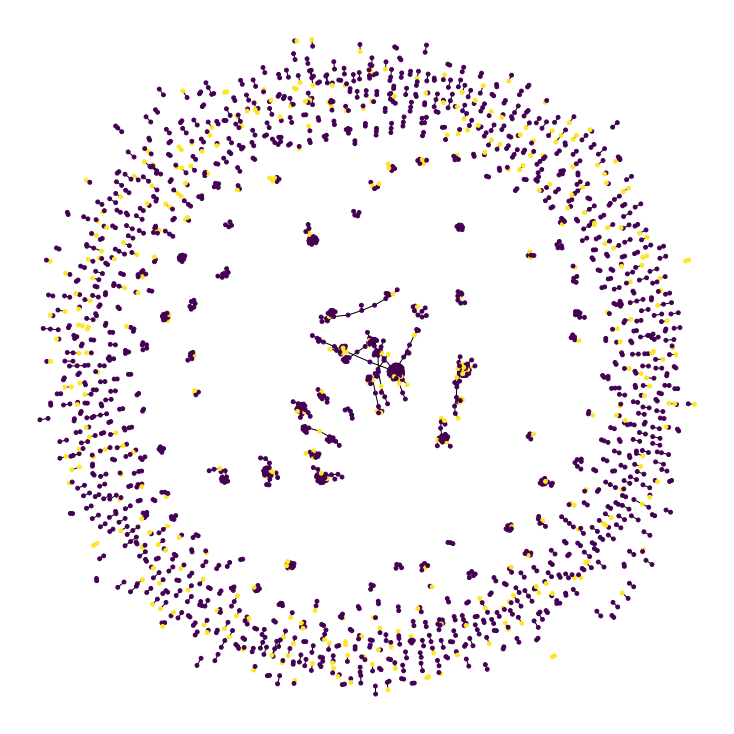

In [20]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

In [21]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (19021, 10)
Test data shape: (18679, 10)


In [22]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.relu)) # Maybe Change

    return keras.Sequential(fnn_layers, name=name)


feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]



# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 289003)
Nodes shape: (37700, 8)


In [23]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        self.update_fn = create_ffn(hidden_units, dropout_rate)
        self.normalize = normalize
            
    def prepare(self, node_repesentations, weights=None):

        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):

        num_nodes = tf.math.reduce_max(node_indices) + 1
        
        aggregated_message = tf.math.unsorted_segment_mean(neighbour_messages, node_indices, num_segments=num_nodes)

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        
        h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        node_embeddings = self.update_fn(h)
        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        
        return node_embeddings

    def call(self, inputs):

        node_repesentations, edges, edge_weights = inputs
        node_indices, neighbour_indices = edges[0], edges[1]
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        
        return self.update(node_repesentations, aggregated_messages)

In [24]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

In [25]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 15
batch_size = 256

In [26]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[ 631.8343  -295.39374]
 [ 277.2313  -236.6601 ]
 [ 545.1798  -552.2742 ]], shape=(3, 2), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (37700, 32)               1504      
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 postprocess (Sequential)    (37700, 32)               2368      
                                                                 
 logits (Dense)              multiple                 

In [27]:


def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=10, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history


def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [28]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/15
64/64 [==============================] - 46s 696ms/step - loss: 0.6147 - acc: 0.7246 - val_loss: 0.5850 - val_acc: 0.7512
Epoch 2/15
64/64 [==============================] - 43s 678ms/step - loss: 0.5753 - acc: 0.7400 - val_loss: 0.5566 - val_acc: 0.7512
Epoch 3/15
64/64 [==============================] - 43s 676ms/step - loss: 0.5685 - acc: 0.7402 - val_loss: 0.5501 - val_acc: 0.7512
Epoch 4/15
64/64 [==============================] - 43s 680ms/step - loss: 0.5686 - acc: 0.7401 - val_loss: 0.5483 - val_acc: 0.7512
Epoch 5/15
64/64 [==============================] - 42s 660ms/step - loss: 0.5658 - acc: 0.7401 - val_loss: 0.5324 - val_acc: 0.7512
Epoch 6/15
64/64 [==============================] - 42s 658ms/step - loss: 0.5637 - acc: 0.7398 - val_loss: 0.5394 - val_acc: 0.7512
Epoch 7/15
64/64 [==============================] - 44s 684ms/step - loss: 0.5638 - acc: 0.7402 - val_loss: 0.5380 - val_acc: 0.7512
Epoch 8/15
64/64 [==============================] - 43s 677ms/step - 

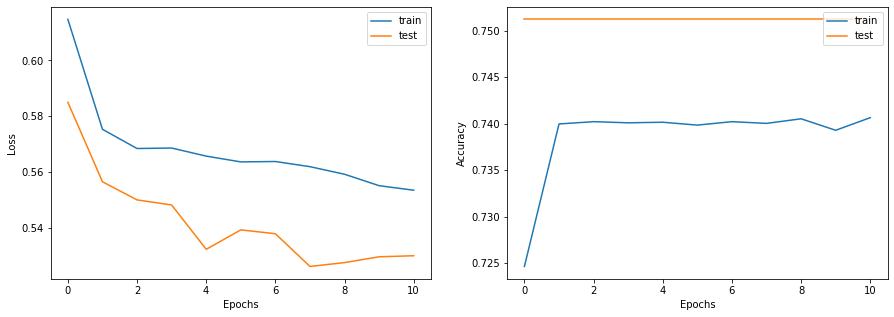

In [29]:
display_learning_curves(history)

In [30]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 74.15%
